The following is the code to analyze the three pattern experiment. In this experiments, after receiving a few 10 min sessions in closed-loop with the bar, the flies were exposed to a session in which there were 3 types of stimulus:
-a 2 px blue bar in closed-loop
-panels off
-a 1 px horizontal bar in the midline of the arena with lower contrast to match the intensity of the 2 px bar
The stimuli changed every 60 sec in a fixed way.

In [1]:
#Import all the modules we will be using

import os
import scipy.io as sio
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
from scipy.stats import circstd
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter
from scipy.optimize import curve_fit

In [2]:
#Load data for single analyses
mainDir = os.getcwd()[:-7]

In [4]:
folders = os.listdir(mainDir + '\data\\three_patterns')  #get the list of folders in it
flyNum = len(folders) #determine fly number

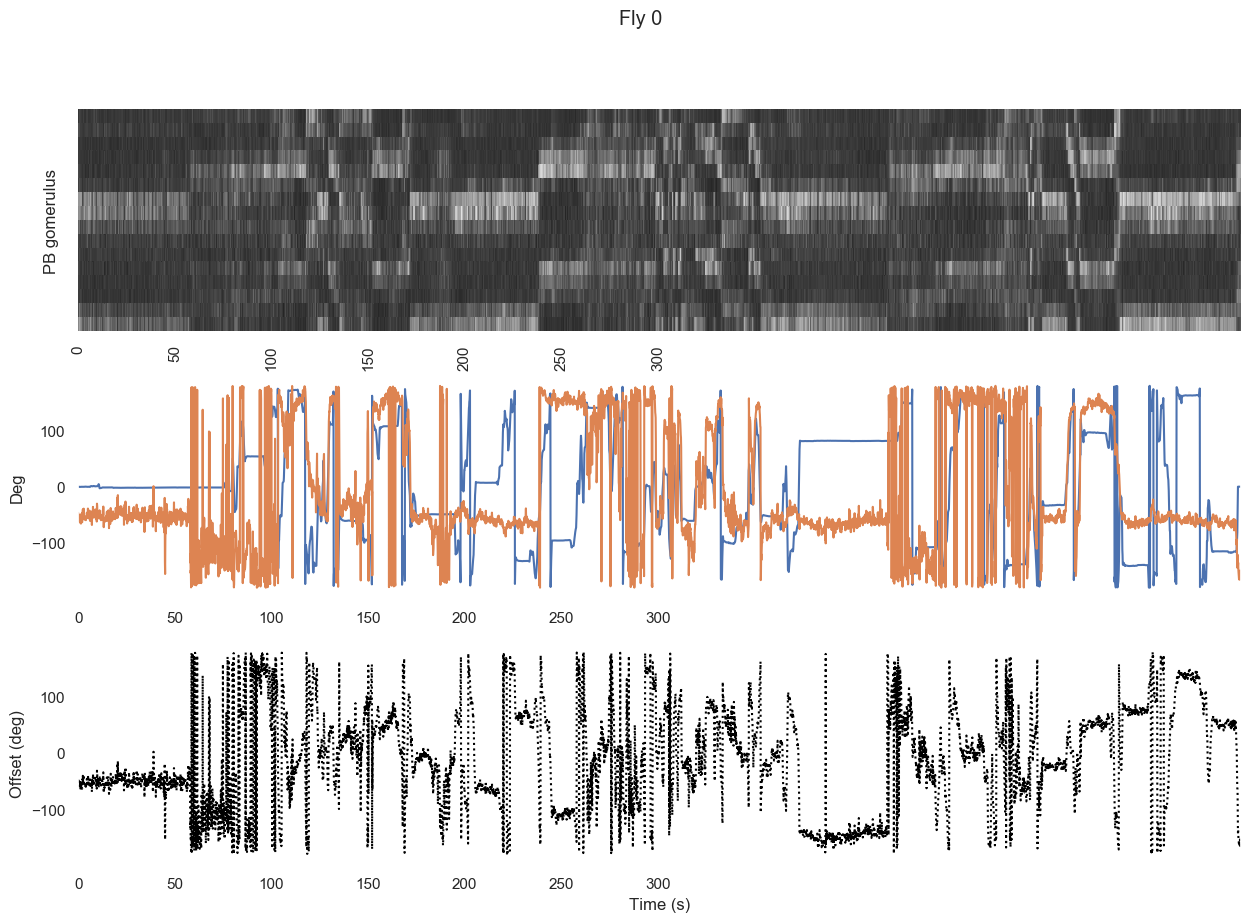

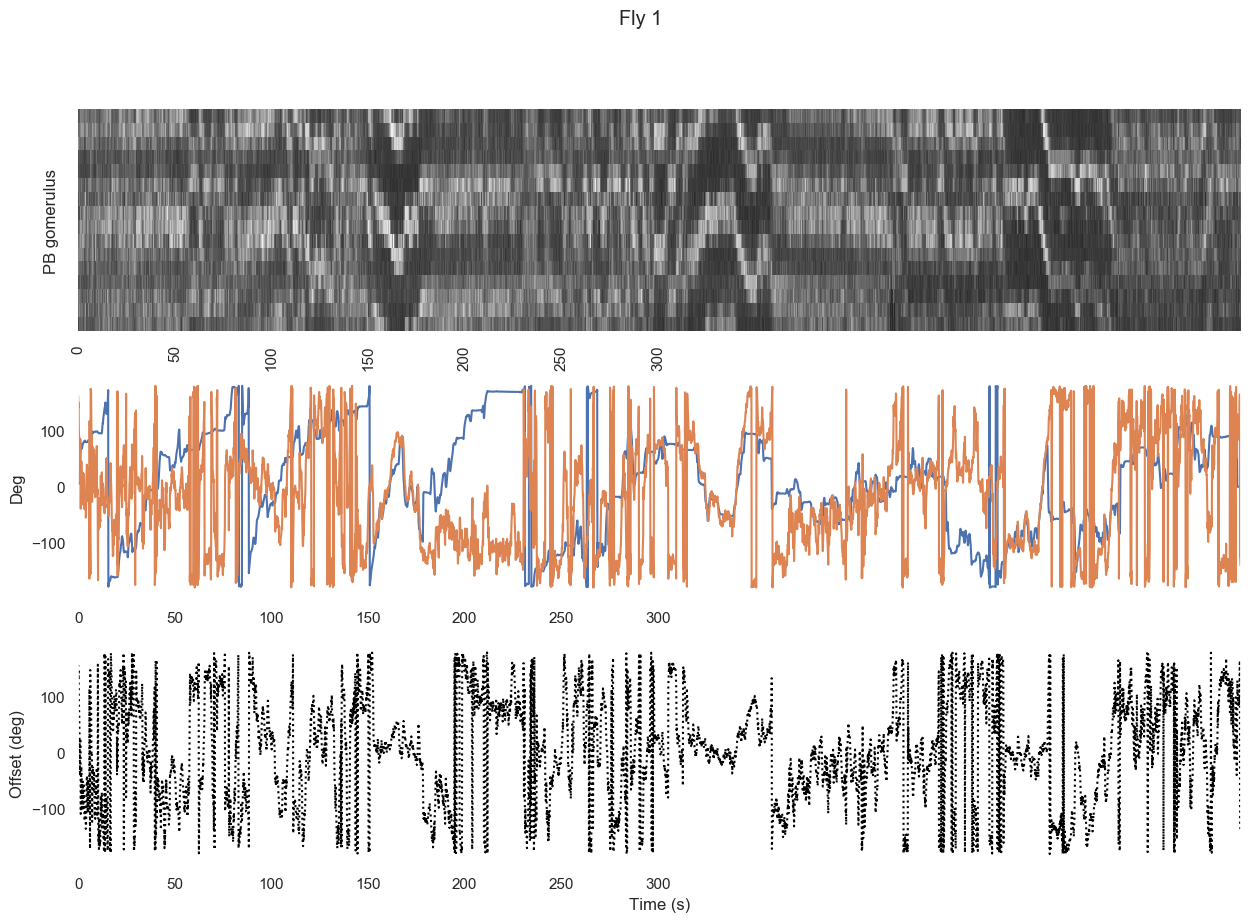

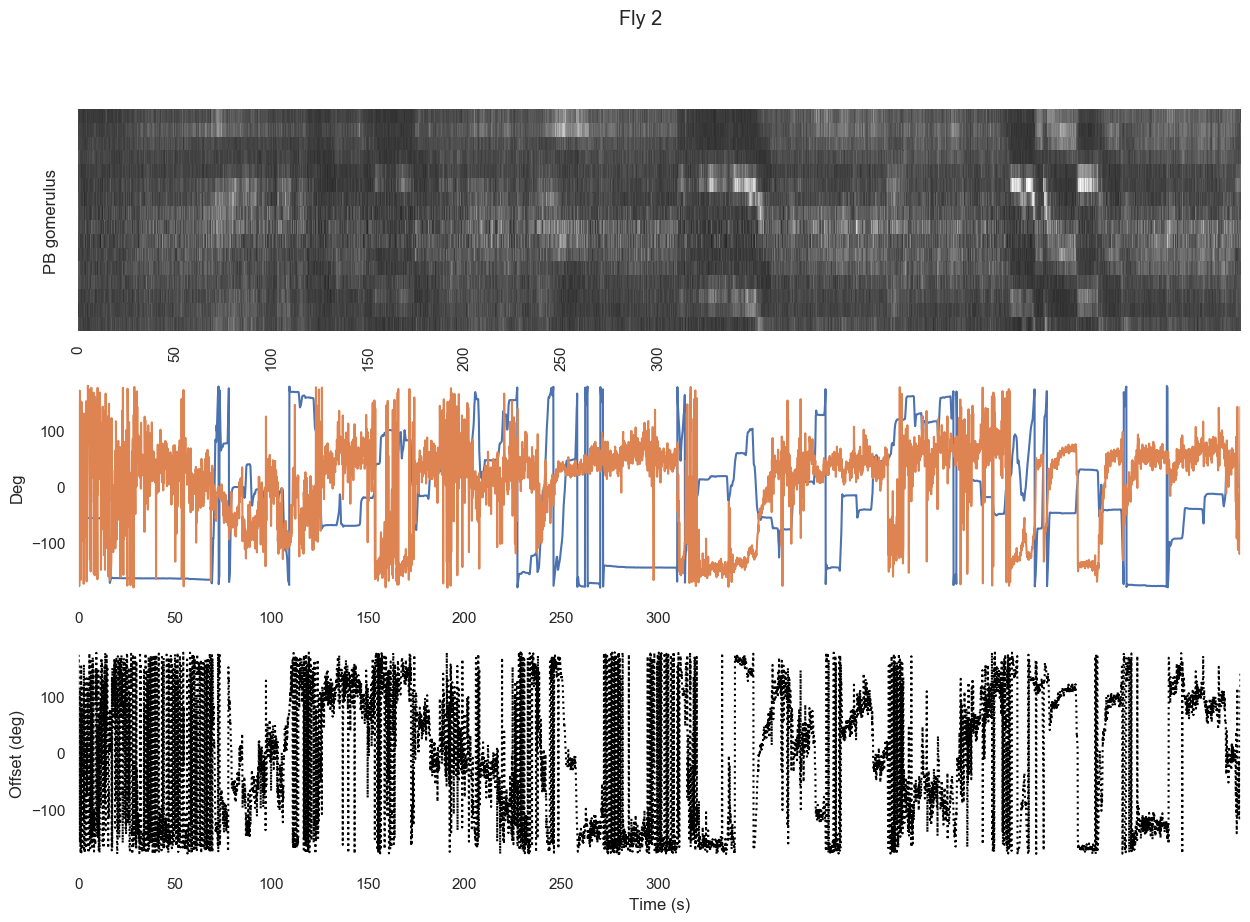

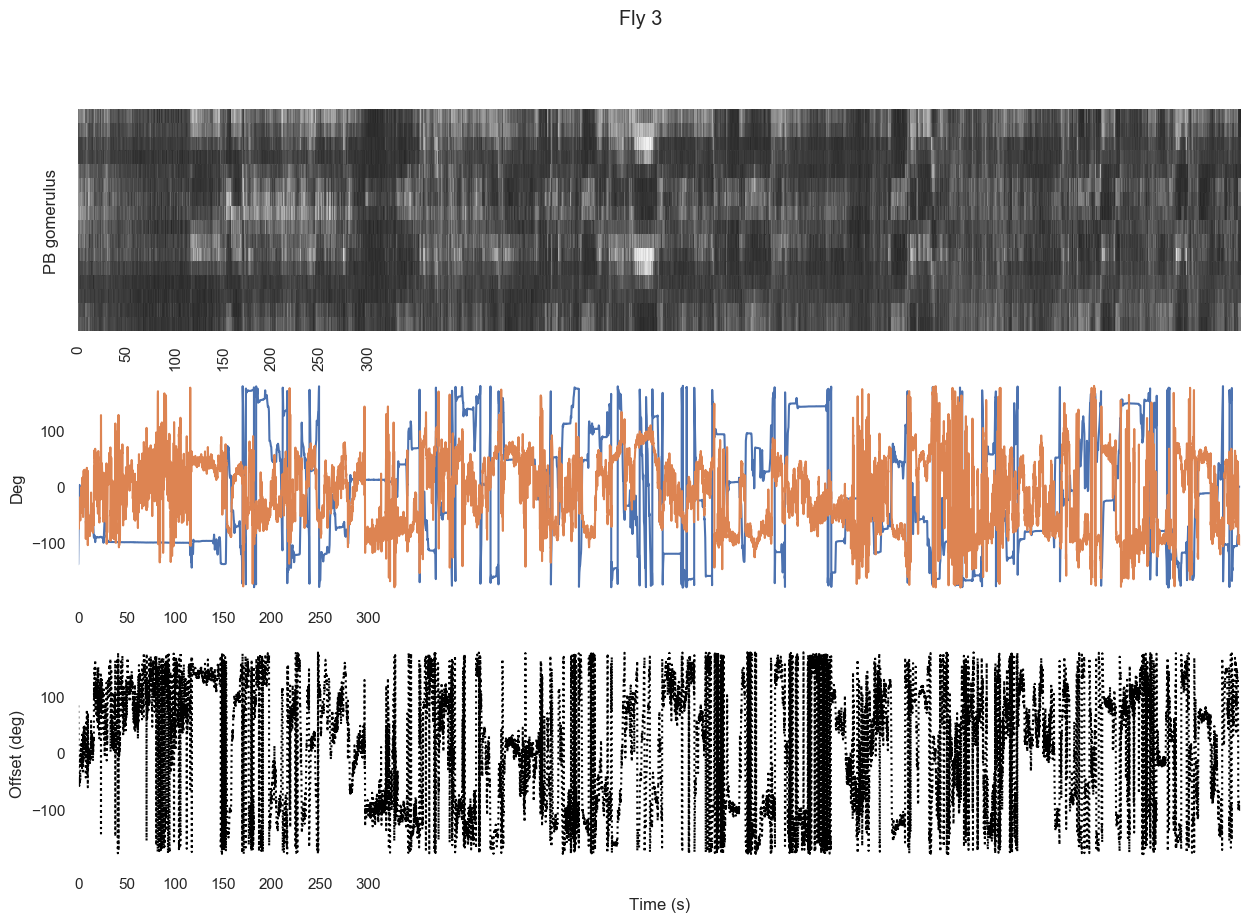

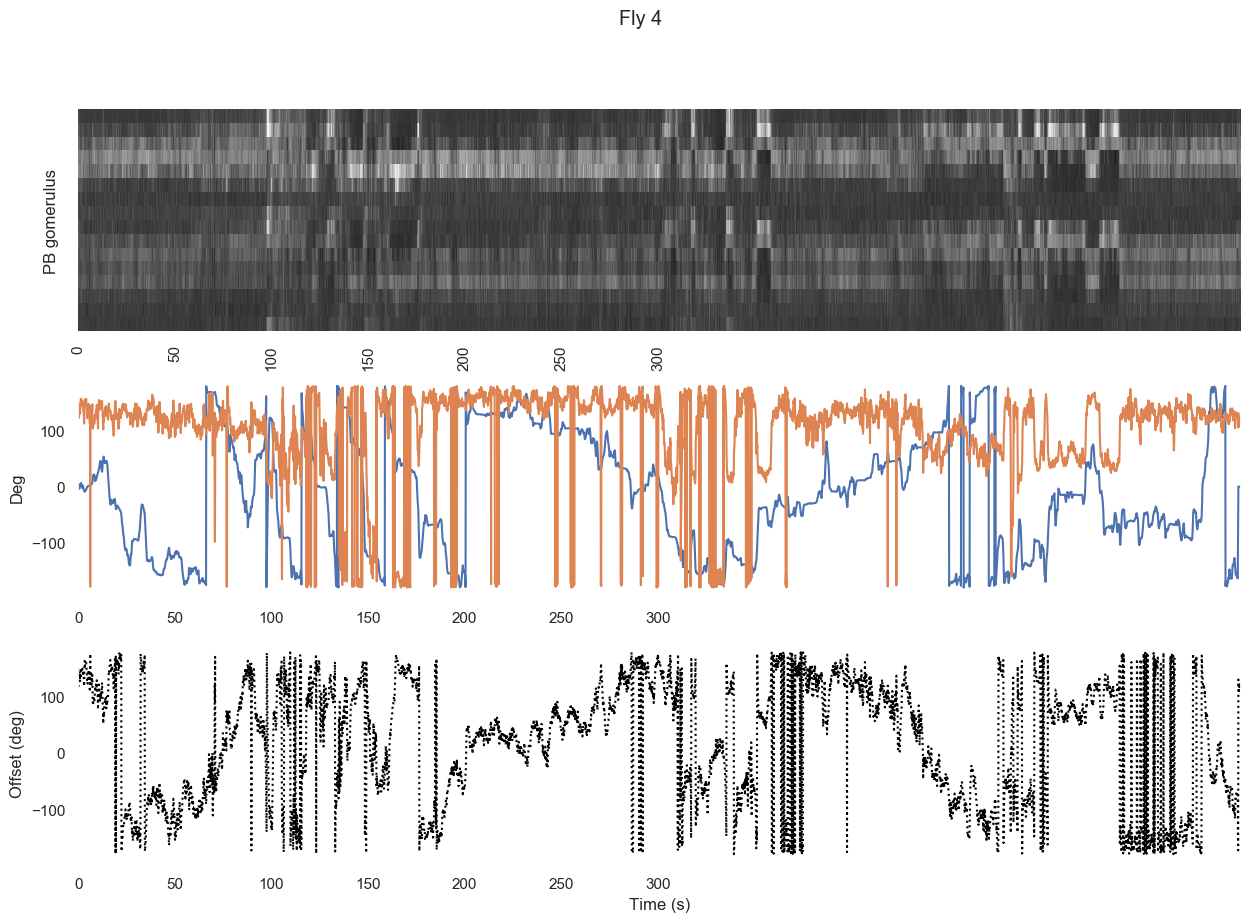

In [8]:
#For each fly, plot the heatmap for the neural data, the fly heading and EPG phase, and the offset

groupData = {}

for fly in range(flyNum): #for each of the folders
    os.chdir(mainDir + '\data\\three_patterns\\' + folders[fly]) #move inside of the folder, inside the dark trial folder
    file = os.listdir() #get the file names
    data = sio.loadmat(file[0], struct_as_record=False) #load the file. This is loaded as a dictionnary, where the data is stored in a dictionnary key called 'data' (you can see this bu running dict.keys())   
    flyData = data['data'] #store only the data from that dictionnary object into a new object called flyData. This is now a numpy.ndarray 
    
    #plot heatmap of neural activity
    dff_matrix = flyData[0,0].dff_matrix
    my_cmap = sns.dark_palette("white", as_cmap=True)
    fig,(ax1, ax2, ax3) = plt.subplots(3,1, figsize = (15, 10), dpi=100)
    fig.suptitle('Fly ' + str(fly))
    g = sns.heatmap(dff_matrix,cmap=my_cmap,ax=ax1, cbar=False)
    g.set(xticklabels=[])
    g.set(yticklabels=[])
    g.set_ylabel('PB gomerulus')  

    ax2 = plt.subplot(312, sharex=ax1)
    ax2.plot(np.rad2deg(flyData[0,0].flyPosRad))  
    ax2.plot(np.transpose(np.rad2deg(flyData[0,0].phase)))   
    ax2.set(xticklabels=[])
    ax2.set(ylabel='Deg')
    ax2.set_facecolor('white')
      
    ax3 = plt.subplot(313, sharex = ax1)
    offset =  np.transpose((np.rad2deg(flyData[0,0].offset3))) 
    ax3.plot(np.transpose((np.rad2deg(flyData[0,0].offset3))),color ='black',linestyle=':')    
    ax3.set_facecolor('white')
    plt.ylabel('Offset (deg)')
    plt.xlabel('Time (s)')
    x_locations = np.arange(0, len(flyData[0,0].time), 458)
    ax3.set_xticks(x_locations)
    ax3.set_xticklabels(('0','50','100','150','200','250','300')) #get a better handle on time
    
    #save data in group data structure
    groupData[fly] = flyData #I'm missing the necessary field names
    
    plt.savefig(mainDir + "\plots\IndividualPlotsFly"  + str(fly) + ".png", dpi=150)

In [9]:
#Determine the timepoints for each type of stimulus

singleBar = np.where(flyData[0,0].fr_y_ds<4)
startSingleBar = np.where(np.ediff1d(singleBar[0])>1)
startPointSingleBar = np.zeros((1,len(startSingleBar[0])))
for i in range(len(startSingleBar[0])):
    startPointSingleBar[0,i] = int(startSingleBar[0][i])   
    
ambiguous = np.where((flyData[0,0].fr_y_ds>6) & (flyData[0,0].fr_y_ds<8))
startAmbiguous = np.where(np.ediff1d(ambiguous[0])>1)
startPointAmbiguous = np.zeros((1,len(startAmbiguous[0])))
for i in range(len(startAmbiguous[0])):
    startPointAmbiguous[0,i] = int(startAmbiguous[0][i])      
    
darkness = np.where(flyData[0,0].fr_y_ds>9)
startDarkness = np.where(np.ediff1d(darkness[0])>1)
startPointDarkness = np.zeros((1,len(startDarkness[0])))
for i in range(len(startDarkness[0])):
    startPointDarkness[0,i] = int(startDarkness[0][i])   

#find coordinates where stimuli change
changingPoints = np.where(abs(np.ediff1d(flyData[0,0].fr_y_ds))>1)

In [10]:
#Create data frame with offset, smoothed offset, time, and stimulus type

newData = []
stimulus = []
smoothedData = []
frames = np.shape(flyData[0,0]['time'])[1]





TypeError: 'mat_struct' object is not subscriptable

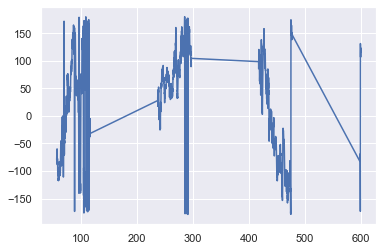

In [19]:
test = np.asarray(darkness[0])



for fly in range(flyNum):
        newData.append(np.apply_along_axis(stat_range, 0, flyGroupData[0,fly]['offset3']))
        stimulus.extend(np.repeat(np.array(1),flyGroupData[0,fly]['StartDarkness'][0,0]))
        stimulus.extend(np.repeat(np.array(2),flyGroupData[0,fly]['EndDarkness'][0,0]-flyGroupData[0,fly]['StartDarkness'][0,0]))
        stimulus.extend(np.repeat(np.array(3),frames-flyGroupData[0,fly]['EndDarkness'][0,0]))
        smoothedData.append(gaussian_filter(newData[fly], sigma=5)) #change sigma for the smoothing window
                
bumpData = np.reshape(np.array(newData),flyNum*len(newData[0]))
smoothedBumpData = np.reshape(np.array(smoothedData),flyNum*len(smoothedData[0]))
flyID = np.repeat(np.array(range(flyNum))+1,frames)
time = [flyData[0,0].time,flyData[0,0].time,flyData[0,0].time]
time = np.reshape(time,frames*3)

# Combine all the data in a dataframe
bumpdata = {'Fly ID': flyID, 'State': state, 'BumpMagMinMax': bumpData, 'Time': time, 'SmoothedBumpMagMinMax': smoothedBumpData}
bumpDF = pd.DataFrame(bumpdata)

g = sns.relplot("Time", "Offset", data=bumpDF, row='Fly ID', hue = 'State', kind="line")
g._legend.remove()
plt.gcf().set_size_inches(20, 10)
